In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import numpy as np
import seaborn as sns

In [38]:
# Recreate scatter plots with both labels and legend
import pandas as pd

# Load the CSV file to check its structure and content
file_path = '/home/duchuheng/vattention/pod_attn/profile_pod.csv'
data = pd.read_csv(file_path)

# divide avg by 1e6
data['avg'] = data['avg'] / 1e3

# Display the first few rows of the dataset to understand its structure
print(data.columns)

Index(['ratio', 'p_cl', 'd_cl', 'p_bs', 'method', 'avg'], dtype='object')


In [41]:
def plot_scatter_point(data, ratio):
    # select ratio
    data = data.loc[data['ratio'] == ratio]

    # check if the data is empty
    if data.empty:
        print("No data found for the given ratio")
        return

    # Group data by 'ratio', 'p_cl', and 'd_cl'
    grouped_data = data.groupby(['ratio', 'p_cl', 'd_cl'])

    # Colors for methods
    method_colors = sns.color_palette("husl", n_colors=len(data['method'].unique()))

    # Initialize a 3x3 plot grid
    fig, axes = plt.subplots(4, 4, figsize=(18, 18))
    fig.tight_layout(pad=5.0)

    # Iterate through groups and plot
    for ax, ((ratio, p_cl, d_cl), group) in zip(axes.flatten(), grouped_data):
        # Calculate latency and throughput
        group['latency'] = 1 / group['avg']
        group['throughput'] = group['p_bs'] * (1 + ratio) / group['avg']
        
        # Scatter plot for each method in the group
        for method, color in zip(group['method'].unique(), method_colors):
            method_data = group[group['method'] == method]
            ax.scatter(
                method_data['latency'],
                method_data['throughput'],
                label=method,
                color=color,
                # point size
                s=100
            )
            # Attach p_bs as labels to points
            for i, row in method_data.iterrows():
                ax.text(
                    row['latency'],
                    row['throughput'],
                    f"{row['p_bs']}",
                    fontsize=12,
                    ha='right'
                )
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
            ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
        
        # Title and labels
        ax.set_title(f"Ratio={ratio}, p_cl={p_cl}, d_cl={d_cl}")
        ax.set_xlabel('Batch Speed (1/ms)')
        ax.set_ylabel('Throughput (req/ms)')
        ax.legend()
    
    # common x,y-axis label
    # fig.text(0.5, 0.04, 'Latency (ms)', ha='center', va='center')
    # fig.text(0.06, 0.5, 'Throughput (req/s)', ha='center', va='center', rotation='vertical')

    # Show the plot
    plt.show()

# print the unique values in 'ratio', 'p_cl', 'd_cl' columns
print(data['ratio'].unique())
print(data['p_cl'].unique())
print(data['d_cl'].unique())

[ 8 16 32]
[  64  256 1024 4096]
[  64  256 1024 4096]


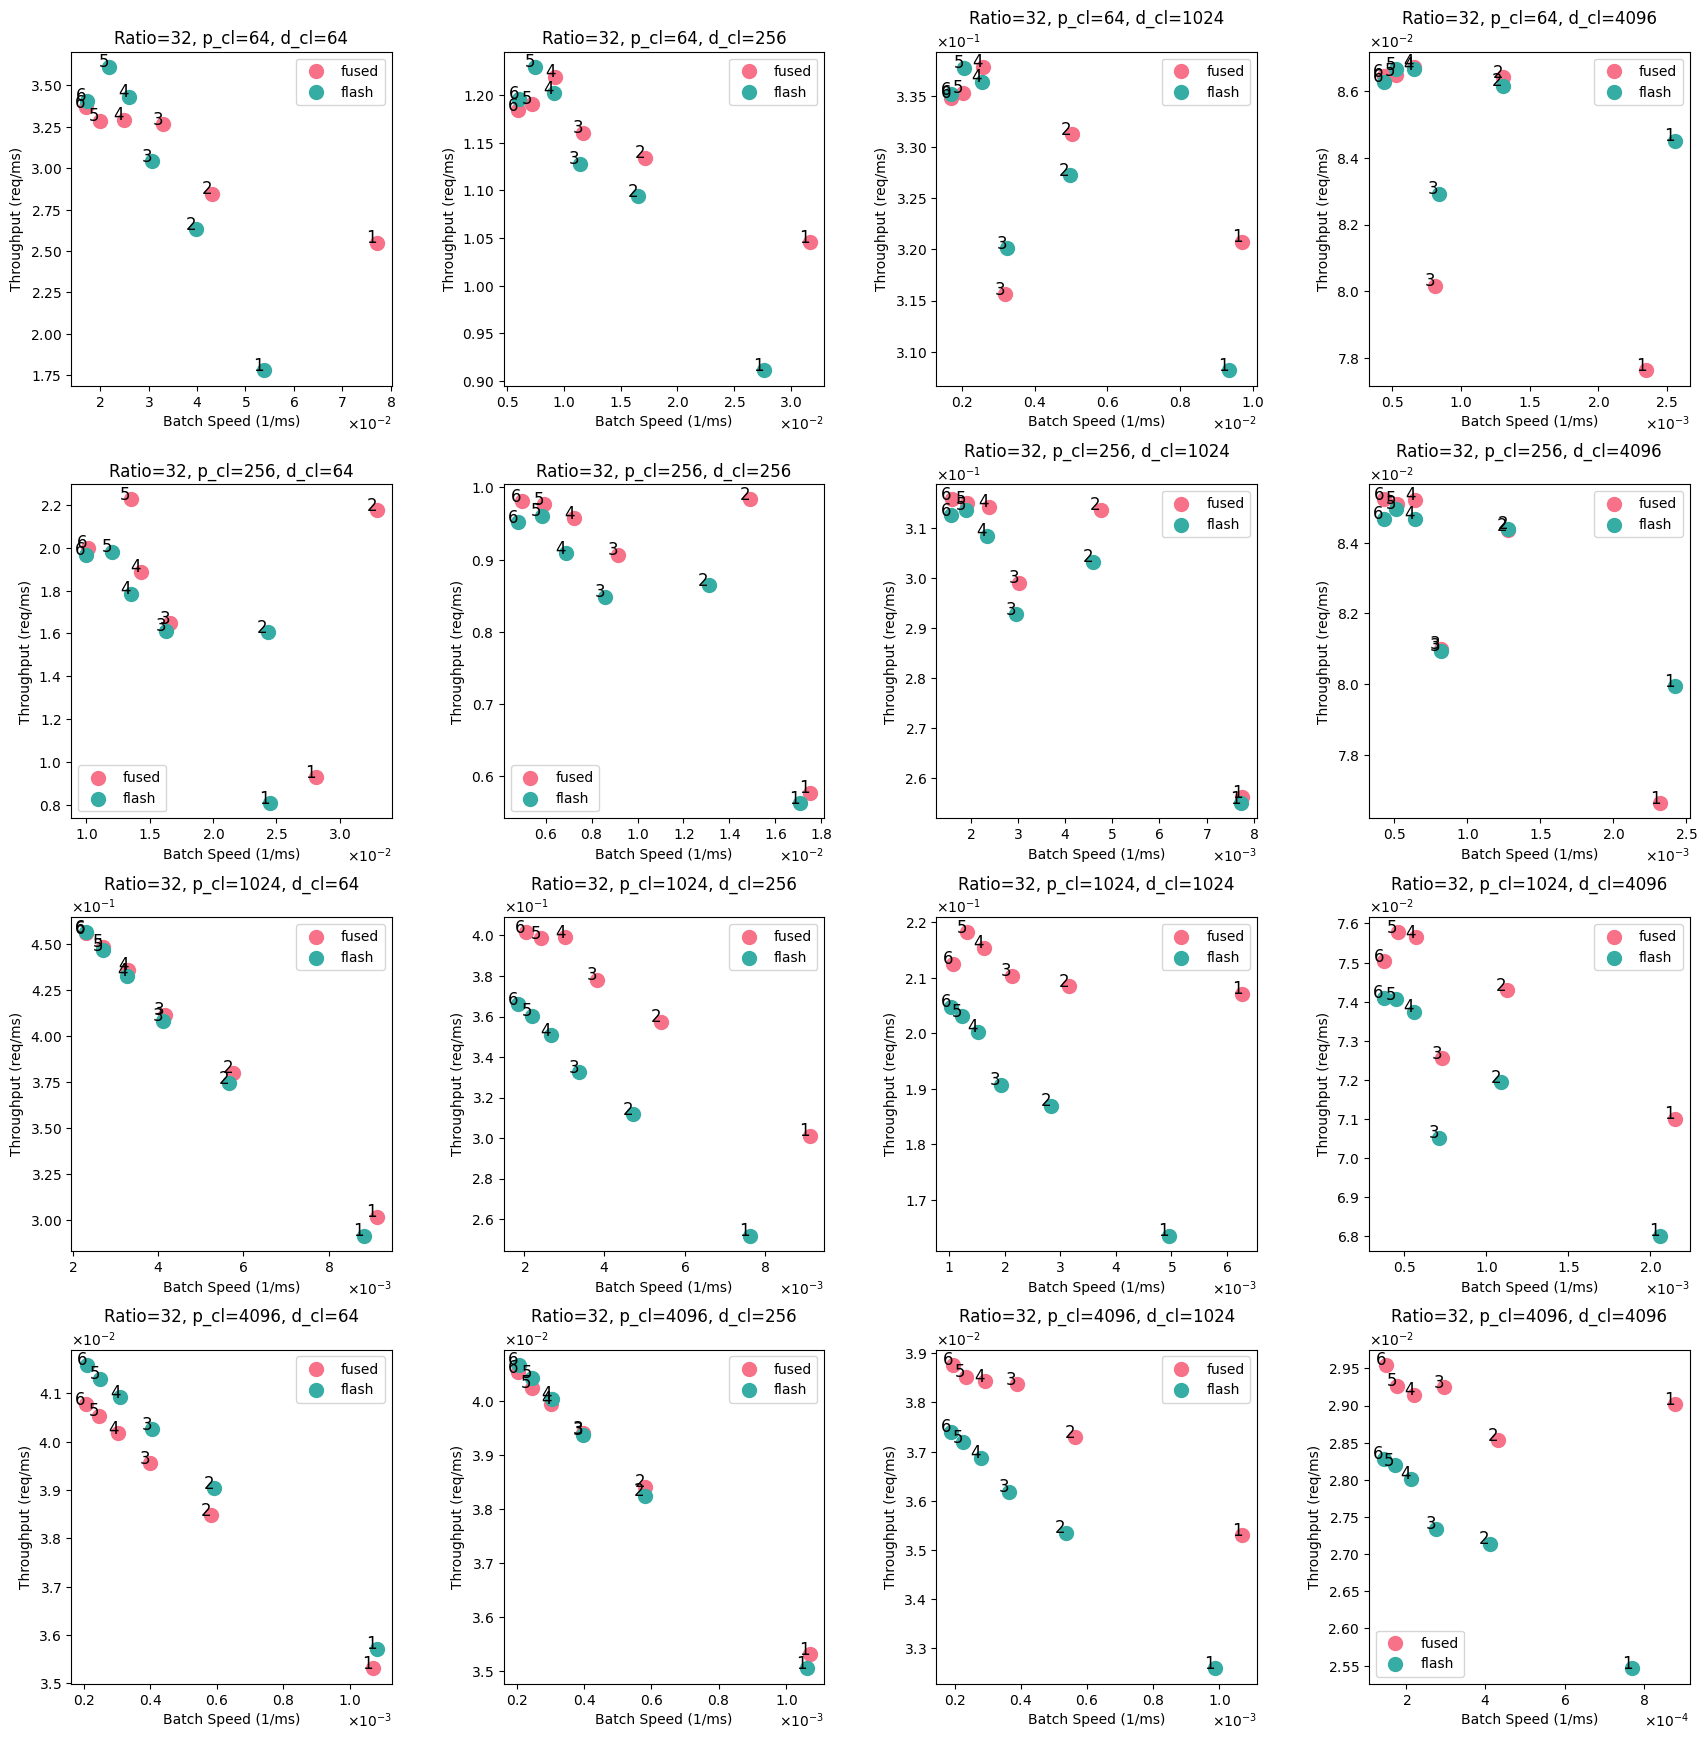

In [45]:
plot_scatter_point(data, 32)

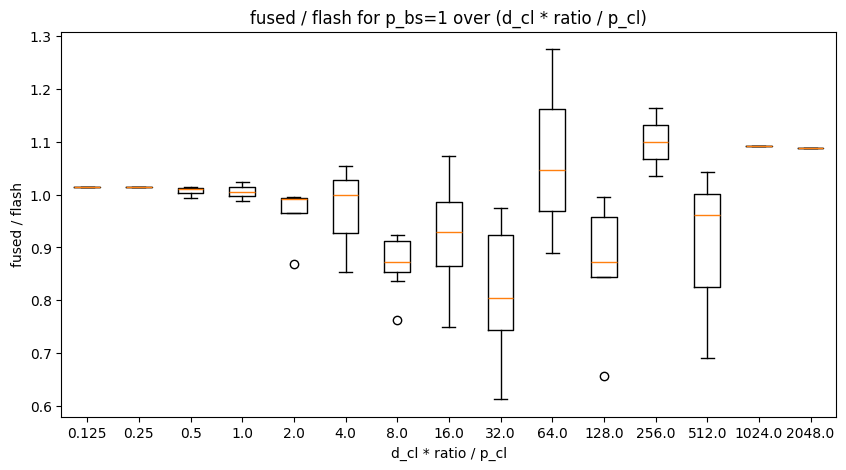

In [36]:
def plot_2(data, b_ps):
    # Group data by 'ratio', 'p_cl', and 'd_cl'
    data = data.loc[data['p_bs'] == b_ps]
    grouped_data = data.groupby(['ratio', 'p_cl', 'd_cl'])
    data_dict = {}
    for (ratio, p_cl, d_cl), group in grouped_data:
        x = float(d_cl * ratio / p_cl)
        fused_y = group[group['method'] == 'fused']['avg'].values[0]
        flash_y = group[group['method'] == 'flash']['avg'].values[0]
        y_list = data_dict.get(x, [])
        y_list.append(float(fused_y / flash_y))
        data_dict[x] = y_list
    # plot the boxplot
    # the x-axis is the index, but with text label
    x = list(data_dict.keys())
    x.sort()
    plt.figure(figsize=(10, 5))
    plt.boxplot([data_dict[key] for key in x])
    plt.xlabel('d_cl * ratio / p_cl')
    plt.xticks(range(1, len(x) + 1), x)
    plt.ylabel('fused / flash')
    plt.title(f'fused / flash for p_bs={b_ps} over (d_cl * ratio / p_cl)')
    plt.show()

plot_2(data, 1)